<a href="https://colab.research.google.com/github/mogesTesema/Machine-Learning-Mastery-With-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with TensorFlow part 3: scaling up food vision min
We've seen the power of transfer leanring feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101.
our goal is to beat the original food101 paper with 10% of the training (leveraging the power of transfer learning)

In [1]:
# lownload helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py


--2025-10-22 09:28:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-10-22 09:28:35 (121 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
!nvidia-smi

Wed Oct 22 09:28:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

In [4]:
# 101 food class woring with less data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-10-22 09:28:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  63.9MB/s    in 22s     

2025-10-22 09:29:01 (70.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")
train_dir = "101_food_classes_10_percent/train"
test_dir =  "101_food_classes_10_percent/test"

In [6]:
walk_through_dir("101_food_classes_10_percent/")

There are 2 directories and 0 images in '101_food_classes_10_percent/'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/poutine'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_

In [8]:
import tensorflow as tf
IMAGE_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=IMAGE_SIZE,
                                                                                label_mode="categorical",
                                                                                )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes
Here are the steps we're going to take:
*  Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augementaiton right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model(we'll create our own output layer)
* Compile our model
* feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch)                                                                           
                                                                                                                                          
                                                                              
                                                                             

In [12]:
# Create a modelcheckpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/ckpt/checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                               monitor="val_accuracy",
                                                               mode="max",
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               save_freq="epoch"

                                                               )

In [21]:
# Build a headless functional api model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

In [24]:
for index, layer in enumerate(base_model.layers):
  print(index,layer.name,layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [23]:
# freeze the model
base_model.trainable = False


In [29]:
# Data augmentation layer
inputs = tf.keras.layers.Input(shape=(224,224,3),
                               name="inputs")
x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomHeight(0.2)(x)
x = tf.keras.layers.RandomWidth(0.2)(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)
# x= tf.keras.layers.Rescaling(0.2)(x) # rescale inputs between 0 and 1 but we don't need rescaling since efficientNet has rescaling built in feature


# setup model architecture with trainable top layers
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="Pooling_layer")(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax',name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [30]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_3 (RandomHeight)  │ (None, None, 224, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_3 (RandomWidth)    │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, None, None, 3)  │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [37]:
# compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [38]:
# feature extract the model
history_model = model.fit(train_data_all_10_percent,
                          epochs=5,
                          steps_per_epoch=len(train_data_all_10_percent),
                          validation_data=test_data,
                          validation_steps=int(0.15*len(test_data)),
                          callbacks=[checkpoint_callback]
                              )


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 173ms/step - accuracy: 0.1537 - loss: 3.9764 - val_accuracy: 0.4309 - val_loss: 2.5434
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 155ms/step - accuracy: 0.4656 - loss: 2.3778 - val_accuracy: 0.5119 - val_loss: 2.0661
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.5428 - loss: 1.9461 - val_accuracy: 0.5270 - val_loss: 1.9119
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.5740 - loss: 1.7489 - val_accuracy: 0.5450 - val_loss: 1.7975
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.6151 - loss: 1.5859 - val_accuracy: 0.5546 - val_loss: 1.7405


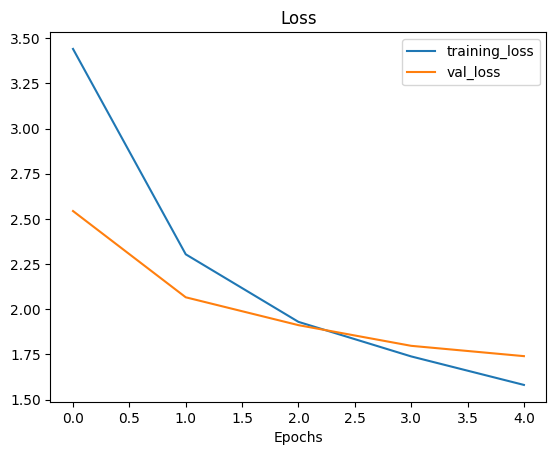

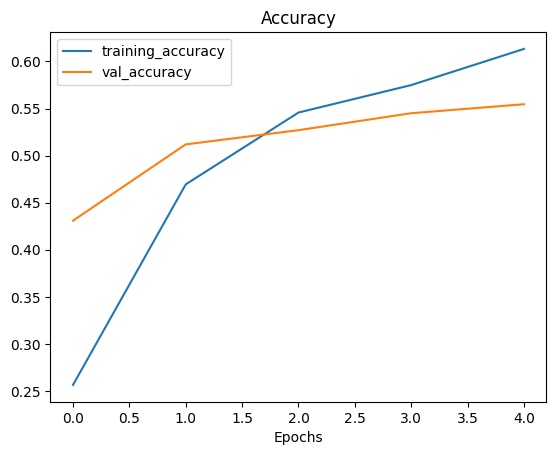

In [39]:
plot_loss_curves(history_model)

In [40]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.5651 - loss: 1.6801


[1.5955301523208618, 0.583207905292511]

## Fine-tune

In [49]:
# unfreeze top 5 layers in base model
total_layer = len(model.layers[6].layers)
for layer_index in range(total_layer-5,total_layer):
  model.layers[6].layers[layer_index].trainable = True



In [58]:
for index,layer in enumerate(model.layers[6].layers):
  print(index,layer.name,layer.trainable)

0 input_layer_2 False
1 rescaling_2 True
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze

In [59]:
# when we change the internal hyperparameter of the model, we have to recompile otherwise we will stay on the same model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001), # learning rate lowered by 10X,it is best for health
              metrics=["accuracy"])

In [61]:
fine_tune_epochs = 5 + 5
fine_tuned_model_history = model.fit(train_data_all_10_percent,
                                     epochs=fine_tune_epochs,
                                     steps_per_epoch=len(train_data_all_10_percent),
                                     validation_data=test_data,
                                     validation_steps=int(0.15 * len(test_data)),
                                     initial_epoch=history_model.epoch[-1],
                                     callbacks=[checkpoint_callback])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.6164 - loss: 1.5591 - val_accuracy: 0.5604 - val_loss: 1.6972
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.6753 - loss: 1.3556 - val_accuracy: 0.5657 - val_loss: 1.6530
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 154ms/step - accuracy: 0.6852 - loss: 1.2663 - val_accuracy: 0.5736 - val_loss: 1.6352
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.6984 - loss: 1.1915 - val_accuracy: 0.5794 - val_loss: 1.6091
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.7058 - loss: 1.1607 - val_accuracy: 0.5808 - val_loss: 1.5844
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 154ms/step - accuracy: 0.7233 - loss: 1.0993 - val_accuracy: 0.5869 - val_loss: 1.5687


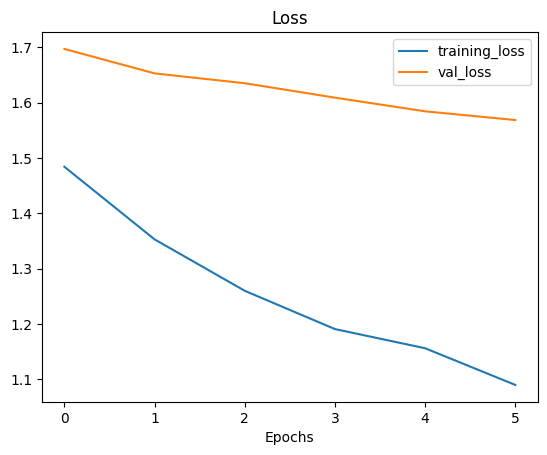

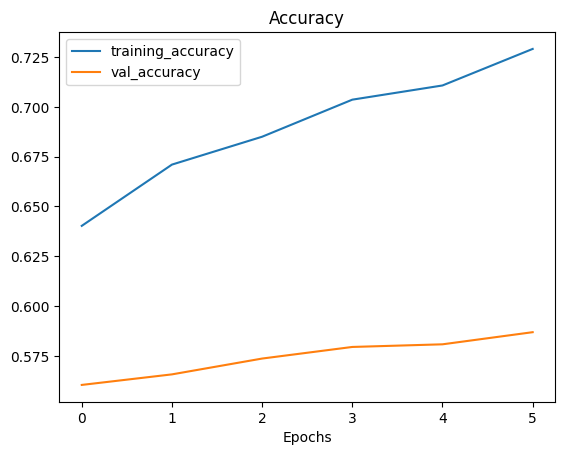

In [62]:
plot_loss_curves(fine_tuned_model_history)